In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve,roc_auc_score
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

In [4]:
file_paths={
    'Sat':'TestbedSatJun12Flows.csv',
    'Sun':'TestbedSunJun13Flows.csv',
    'Mon':'TestbedMonJun14Flows.csv',
    'Tue':'TestbedTueJun15Flows.csv',
    'Wed':'TestbedWedJun16Flows.csv',
    'Thu':'TestbedThuJun17Flows.csv'}

In [9]:
frames=[]
for day,path in file_paths.items():
    data2012=pd.read_csv(path)
    data2012['day']=day
    frames.append(data2012)

all_data2012=pd.concat(frames,ignore_index=True)
print(f"Loaded total rows: {len(all_data2012)}")
all_data2012

Loaded total rows: 2071657


,generated,appName,totalSourceBytes,totalDestinationBytes,totalDestinationPackets,totalSourcePackets,sourcePayloadAsBase64,sourcePayloadAsUTF,destinationPayloadAsBase64,destinationPayloadAsUTF,direction,sourceTCPFlagsDescription,destinationTCPFlagsDescription,source,protocolName,sourcePort,destination,destinationPort,startDateTime,stopDateTime,Label,day
0,3/11/2014 17:23,HTTPWeb,128,64,1,2,NaN,NaN,NaN,NaN,L2R,"F,A","F,A",192.168.1.104,tcp_ip,22441,216.246.64.49,80,6/12/2010 23:58,6/12/2010 23:58,Normal,Sat
1,3/11/2014 17:23,HTTPWeb,128,64,1,2,NaN,NaN,NaN,NaN,L2R,"F,A","F,A",192.168.1.104,tcp_ip,22445,216.246.64.66,80,6/12/2010 23:58,6/12/2010 23:58,Normal,Sat
2,3/11/2014 17:23,HTTPWeb,128,64,1,2,NaN,NaN,NaN,NaN,L2R,"F,A","F,A",192.168.1.104,tcp_ip,22444,216.246.64.66,80,6/12/2010 23:58,6/12/2010 23:58,Normal,Sat
3,3/11/2014 17:23,SSH,2938,49570,76,27,NaN,NaN,NaN,NaN,L2L,"S,R,P,A","S,P,A",192.168.3.115,tcp_ip,3248,192.168.5.122,22,6/12/2010 23:58,6/12/2010 23:58,Normal,Sat
4,3/11/2014 17:23,HTTPImageTransfer,644,2315,5,7,NaN,NaN,NaN,NaN,L2R,"S,P,A","S,P,A",192.168.2.110,tcp_ip,1867,142.166.14.77,80,6/12/2010 23:58,6/12/2010 23:58,Normal,Sat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2071652,3/11/2014 18:28,HTTPWeb,426,808,5,5,R0VUIC9vcmcvZm9ydW0vZGVzaWduaW5nLWJpcnQtcmVwb3...,GET /org/forum/designing-birt-reports-forums/d...,SFRUUC8xLjEgMzAxIE1vdmVkIFBlcm1hbmVudGx5DQpDb2...,HTTP/1.1 301 Moved PermanentlyConnection: clos...,L2R,"F,S,P,A","F,S,P,A",192.168.1.101,tcp_ip,4077,67.111.12.102,80,6/17/2010 23:58,6/17/2010 23:58,Normal,Thu
2071653,3/11/2014 18:28,HTTPWeb,2526,92483,65,38,R0VUIC9vcmcvZm9ydW0vaW5kZXgucGhwL2ZvcnVtLzItZG...,GET /org/forum/index.php/forum/2-designing-bir...,SFRUUC8xLjEgMjAwIE9LDQpDb25uZWN0aW9uOiBjbG9zZQ...,HTTP/1.1 200 OKConnection: closeExpires: 0Date...,L2R,"F,S,P,A","F,S,P,A",192.168.1.101,tcp_ip,4078,67.111.12.102,80,6/17/2010 23:58,6/17/2010 23:58,Normal,Thu
2071654,3/11/2014 18:28,HTTPWeb,310,130,2,3,R0VUIC9vcmcvZm9ydW0vYWQtaG9jLWludGVyYWN0aXZlLX...,GET /org/forum/ad-hoc-interactive-reporting-fo...,SFRUUC8xLjEgMzAxIE1vdmVkIFBlcm1hbmVudGx5DQpDb2...,HTTP/1.1 301 Moved PermanentlyConnection: clos...,L2R,"S,P,A","S,A",192.168.1.101,tcp_ip,4079,67.111.12.102,80,6/17/2010 23:58,6/17/2010 23:58,Normal,Thu
2071655,3/11/2014 18:28,HTTPWeb,426,808,5,5,R0VUIC9vcmcvZm9ydW0vZGVzaWduaW5nLWJpcnQtcmVwb3...,GET /org/forum/designing-birt-reports-forums/d...,SFRUUC8xLjEgMzAxIE1vdmVkIFBlcm1hbmVudGx5DQpDb2...,HTTP/1.1 301 Moved PermanentlyConnection: clos...,L2R,"F,S,P,A","F,S,P,A",192.168.1.101,tcp_ip,4080,67.111.12.102,80,6/17/2010 23:58,6/17/2010 23:58,Normal,Thu


In [4]:
session_2012=['totalSourceBytes','totalDestinationBytes','totalSourcePackets',
    'totalDestinationPackets','direction','sourceTCPFlagsDescription',
    'destinationTCPFlagsDescription','protocolName','sourcePort','destinationPort',
    'startDateTime','stopDateTime']
all_data2012=all_data2012[session_2012+['Label','day']]
all_data2012=all_data2012.copy()

In [5]:
#flow duration
all_data2012['startDateTime']=pd.to_datetime(all_data2012['startDateTime'],errors='coerce')
all_data2012['stopDateTime']=pd.to_datetime(all_data2012['stopDateTime'],errors='coerce')
all_data2012['duration']=(all_data2012['stopDateTime']-all_data2012['startDateTime']).dt.total_seconds()
all_data2012.drop(['startDateTime','stopDateTime'],axis=1,inplace=True)
all_data2012['duration']=all_data2012['duration'].fillna(0).clip(lower=0)

#packet ratio
all_data2012['packet_ratio']=all_data2012['totalSourcePackets']/all_data2012['totalDestinationPackets'].replace(0,np.nan)
all_data2012['packet_ratio']=all_data2012['packet_ratio'].fillna(0).clip(upper=10)

#byte ratio
all_data2012['byte_ratio']=all_data2012['totalSourceBytes']/all_data2012['totalDestinationBytes'].replace(0,np.nan)
all_data2012['byte_ratio']=all_data2012['byte_ratio'].fillna(0).clip(upper=10)

#average packet size source
all_data2012['avg_packet_size_src']=all_data2012['totalSourceBytes']/all_data2012['totalSourcePackets'].replace(0,np.nan)
all_data2012['avg_packet_size_src']=all_data2012['avg_packet_size_src'].fillna(0).clip(upper=1500)

#average packet size destination
all_data2012['avg_packet_size_dst']=all_data2012['totalDestinationBytes']/all_data2012['totalDestinationPackets'].replace(0,np.nan)
all_data2012['avg_packet_size_dst']=all_data2012['avg_packet_size_dst'].fillna(0).clip(upper=1500)

In [6]:
cat_cols_2012=['direction','sourceTCPFlagsDescription','destinationTCPFlagsDescription',
                  'protocolName']
all_data2012 = all_data2012.dropna(subset=['Label'])
for col in cat_cols_2012:
    all_data2012[col] = all_data2012[col].fillna("UNKNOWN")

In [7]:
label_encoders = {}

for col in cat_cols_2012:
    le = LabelEncoder()
    all_data2012[col] = le.fit_transform(all_data2012[col])
    label_encoders[col] = le  

In [8]:
train_days=['Sat','Sun','Mon','Tue']
test_day='Wed'
eval_day='Thu'

train_df=all_data2012[all_data2012['day'].isin(train_days)]
test_df=all_data2012[all_data2012['day']==test_day]
eval_df=all_data2012[all_data2012['day']==eval_day]

X_train=train_df.drop(['Label','day'],axis=1)
y_train=train_df['Label']
X_test=test_df.drop(['Label','day'],axis=1)
y_test=test_df['Label']
X_eval=eval_df.drop(['Label','day'],axis=1)
y_eval=eval_df['Label']

In [9]:
sm=SMOTE(random_state=42)
X_train_res,y_train_res=sm.fit_resample(X_train,y_train)
print(f"Resampled shape: {X_train_res.shape},Attack: {sum(y_train_res==0)},Normal:{sum(y_train_res==1)}")

Resampled shape: (2176238, 15),Attack: 0,Normal:0


In [10]:
clf=RandomForestClassifier(n_estimators=100,max_depth=15,random_state=42,n_jobs=-1)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

In [11]:
print("Test Set Performance (Wed):")
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred, target_names=['Attack', 'Normal']))

Test Set Performance (Wed):
[[    11      0]
 [    42 522210]]
              precision    recall  f1-score   support

      Attack       0.21      1.00      0.34        11
      Normal       1.00      1.00      1.00    522252

    accuracy                           1.00    522263
   macro avg       0.60      1.00      0.67    522263
weighted avg       1.00      1.00      1.00    522263



In [12]:
y_eval_pred=clf.predict(X_eval)
print("Final Evaluation (Thu):")
print(confusion_matrix(y_eval,y_eval_pred))
print(classification_report(y_eval,y_eval_pred, target_names=['Attack', 'Normal']))

Final Evaluation (Thu):
[[  1813   3406]
 [  1596 390780]]
              precision    recall  f1-score   support

      Attack       0.53      0.35      0.42      5219
      Normal       0.99      1.00      0.99    392376

    accuracy                           0.99    397595
   macro avg       0.76      0.67      0.71    397595
weighted avg       0.99      0.99      0.99    397595



In [ ]:
explainer=shap.TreeExplainer(clf)
shap_values=explainer.shap_values(X_test)
shap.summary_plot(shap_values[1],X_test,plot_type="bar")

In [24]:
X_sample = X_test.sample(n=1000, random_state=42)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_sample)

# Inspect structure
print("Type:", type(shap_values))
if isinstance(shap_values, list):
    print("shap_values[0] shape:", shap_values[0].shape)
    print("shap_values[1] shape:", shap_values[1].shape)
else:
    print("shap_values shape:", shap_values.shape)

print("X_sample shape:", X_sample.shape)



Type: <class 'numpy.ndarray'>
shap_values shape: (1000, 15, 2)
X_sample shape: (1000, 15)


 99%|===================| 1974/2000 [01:03<00:00]        

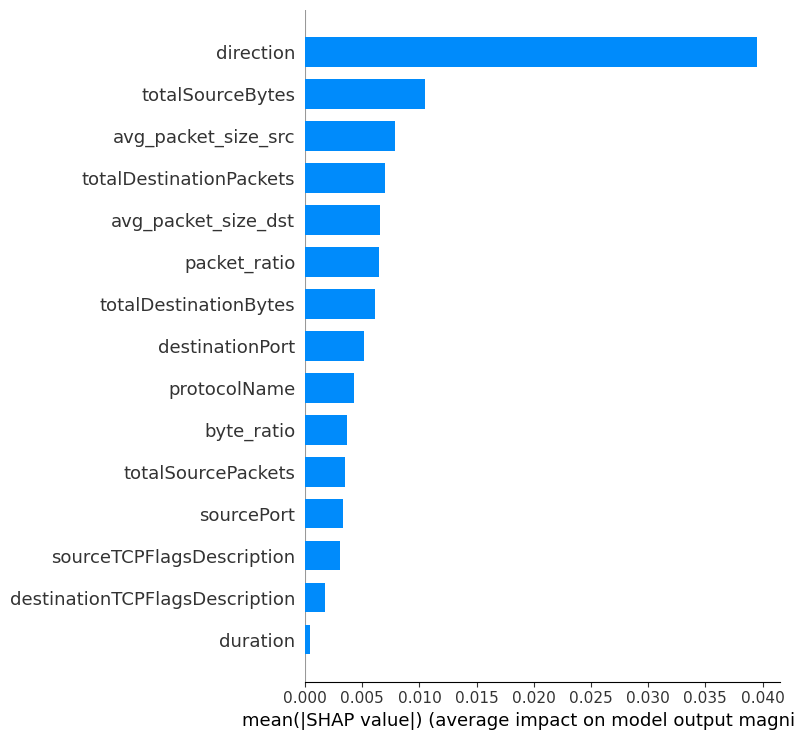

In [29]:
# attack
X_sample = X_test.sample(n=1000, random_state=42)
explainer = shap.Explainer(clf,X_train)  
shap_output = explainer(X_sample)
shap_values = shap_output.values[:, :, 1]
shap.summary_plot(shap_values, X_sample, plot_type="bar")


 99%|===================| 1975/2000 [01:05<00:00]        

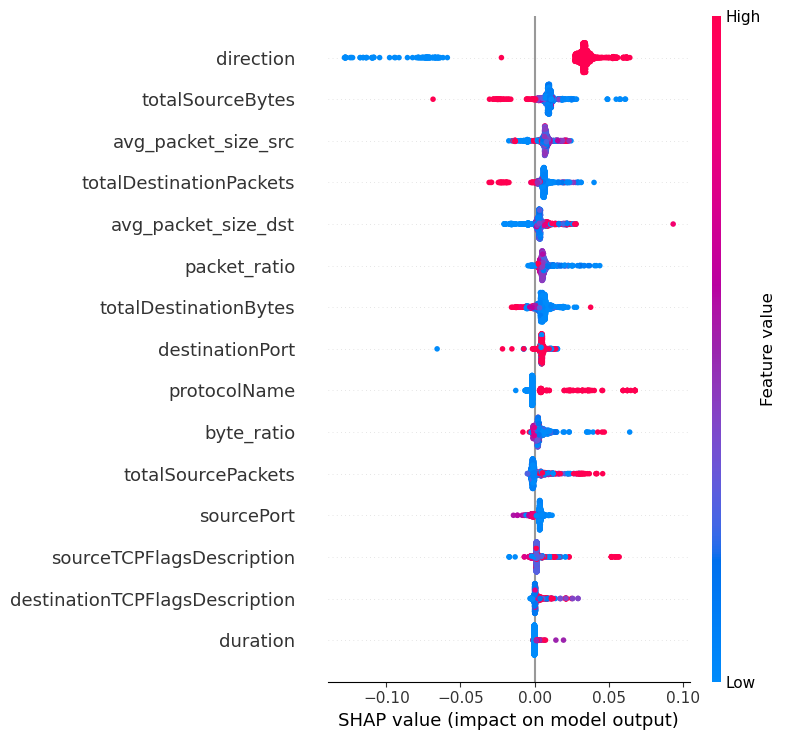

In [32]:
# attack
X_sample = X_test.sample(n=1000, random_state=42)
explainer = shap.Explainer(clf,X_train)  
shap_output = explainer(X_sample)
shap_values = shap_output.values[:, :, 1]
shap.summary_plot(shap_values, X_sample)

 98%|===================| 1969/2000 [01:05<00:01]        

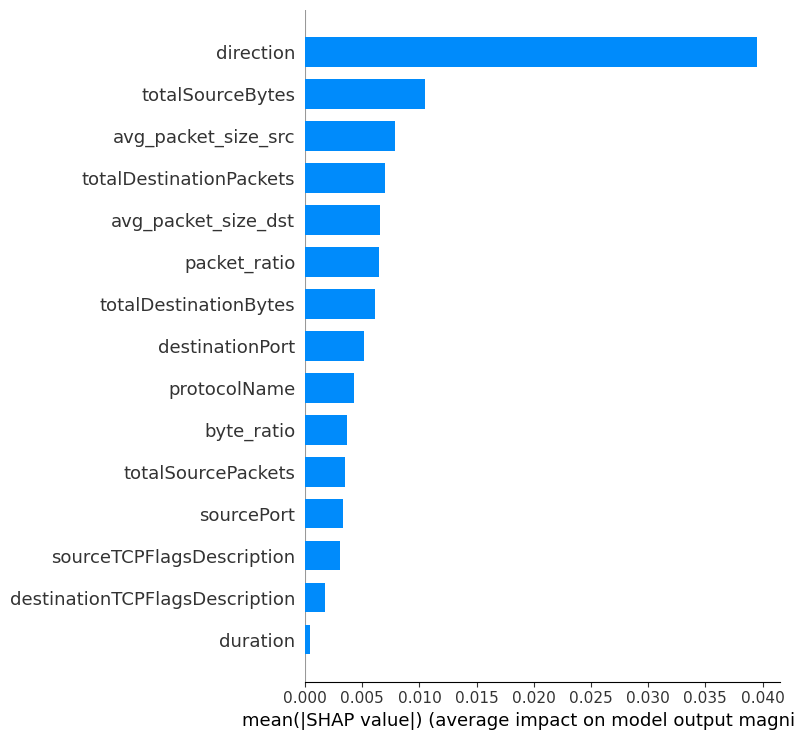

In [30]:
#normal
X_sample = X_test.sample(n=1000, random_state=42)
explainer = shap.Explainer(clf,X_train)
shap_output = explainer(X_sample)
shap_values = shap_output.values[:, :, 0]
shap.summary_plot(shap_values, X_sample, plot_type="bar")

 99%|===================| 1974/2000 [01:04<00:00]        

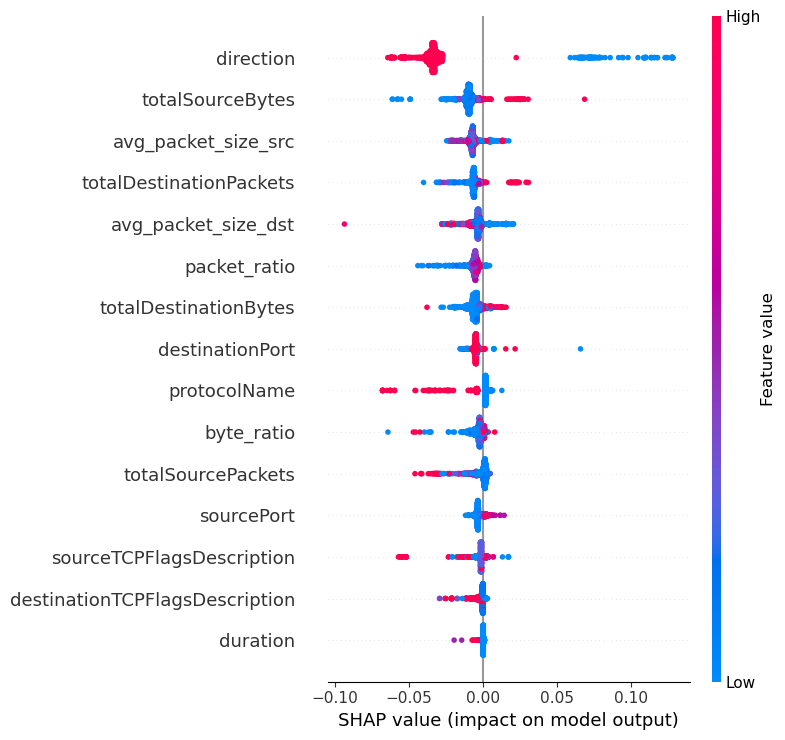

In [33]:
#normal
X_sample = X_test.sample(n=1000, random_state=42)
explainer = shap.Explainer(clf,X_train)
shap_output = explainer(X_sample)
shap_values = shap_output.values[:, :, 0]
shap.summary_plot(shap_values, X_sample)

In [35]:
#3d
explainer = shap.Explainer(clf, X_train)
shap_output = explainer(X_sample)
shap_values = shap_output.values

 99%|===================| 1981/2000 [01:02<00:00]        

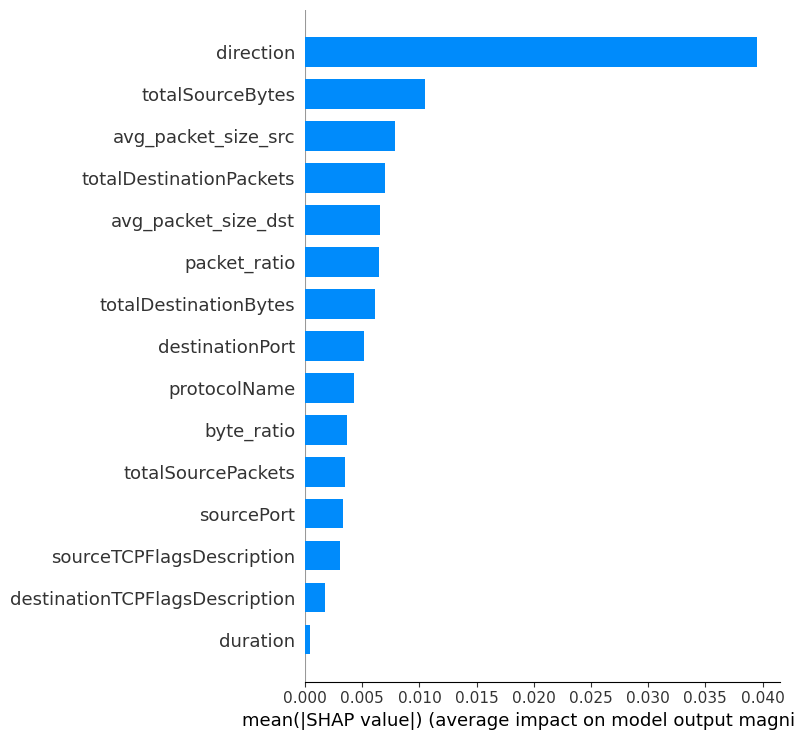

In [36]:
#average
shap_avg = np.abs(shap_values).mean(axis=2) 
shap.summary_plot(shap_avg, X_sample, plot_type="bar")

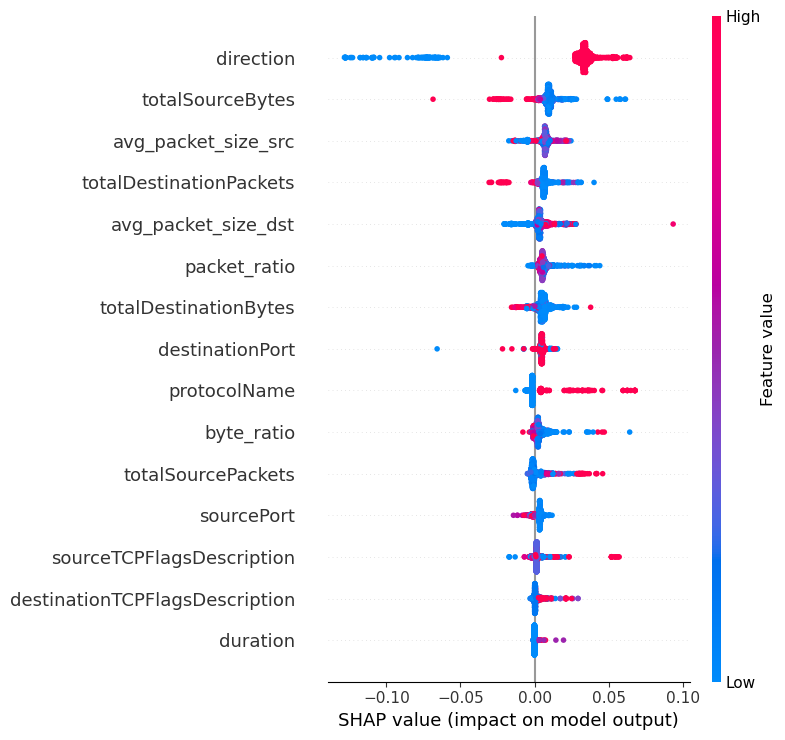

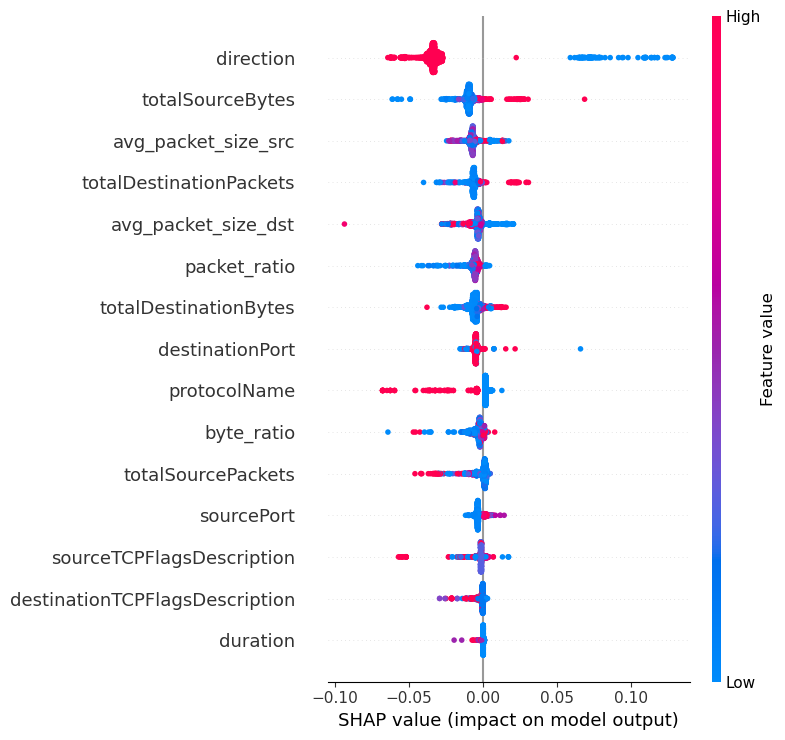

In [37]:
shap.summary_plot(shap_values[:, :, 1], X_sample) #Attack
shap.summary_plot(shap_values[:, :, 0], X_sample) # Normal

In [38]:
features = X_sample.columns

attack_top = pd.Series(np.abs(shap_values[:, :, 1]).mean(axis=0), index=features).sort_values(ascending=False)
normal_top = pd.Series(np.abs(shap_values[:, :, 0]).mean(axis=0), index=features).sort_values(ascending=False)
avg_top = pd.Series(np.abs(shap_values).mean(axis=(0, 2)), index=features).sort_values(ascending=False)

print("Top features for Attack:")
print(attack_top.head(5))
print("\nTop features for Normal:")
print(normal_top.head(5))
print("\nTop average features:")
print(avg_top.head(5))

Top features for Attack:
direction                  0.039548
totalSourceBytes           0.010449
avg_packet_size_src        0.007859
totalDestinationPackets    0.006965
avg_packet_size_dst        0.006525
dtype: float64

Top features for Normal:
direction                  0.039548
totalSourceBytes           0.010449
avg_packet_size_src        0.007859
totalDestinationPackets    0.006965
avg_packet_size_dst        0.006525
dtype: float64

Top average features:
direction                  0.039548
totalSourceBytes           0.010449
avg_packet_size_src        0.007859
totalDestinationPackets    0.006965
avg_packet_size_dst        0.006525
dtype: float64


In [6]:
print("Columns:", data2012.columns.tolist())

Columns: ['generated', 'appName', 'totalSourceBytes', 'totalDestinationBytes', 'totalDestinationPackets', 'totalSourcePackets', 'sourcePayloadAsBase64', 'sourcePayloadAsUTF', 'destinationPayloadAsBase64', 'destinationPayloadAsUTF', 'direction', 'sourceTCPFlagsDescription', 'destinationTCPFlagsDescription', 'source', 'protocolName', 'sourcePort', 'destination', 'destinationPort', 'startDateTime', 'stopDateTime', 'Label', 'day']


In [7]:
pd.set_option('display.max_columns',None)